In [2]:

import os
import plaid
import requests
import datetime
import json
import pandas as pd
%matplotlib inline

def pretty_print_response(response):
  print(json.dumps(response, indent=4, sort_keys=True))

PLAID_CLIENT_ID= '5e8cfcca83c0da0013e6eb79' 
PLAID_SECRET_KEY= '6d776f8ff718ab1f44e9e4c8bdc445' 
PLAID_PUBLIC_KEY= '59b7acfaeb4a1a2852b8f775598574' 
PLAID_PRODUCTS= ('PLAID_PRODUCTS','transactions' )
PLAID_ENV=('sandbox','PLAID_ENV') 


In [3]:
# Create client object
client = plaid.Client(client_id=PLAID_CLIENT_ID, secret=PLAID_SECRET_KEY, public_key=PLAID_PUBLIC_KEY, environment='sandbox')

# Get institutions
INSTITUTION_ID = "ins_109508"
# Create public token to be exchanged for institution access token
create_tkn_response = client.Sandbox.public_token.create(INSTITUTION_ID, ['transactions','income','assets'])

# Exchange public token for access token
exchange_response = client.Item.public_token.exchange(create_tkn_response['public_token'])

# Store access token as variable
access_token = exchange_response['access_token']



In [4]:
# Get transactions for institution for specific date range
start_date = '{:%Y-%m-%d}'.format(datetime.datetime.now() + datetime.timedelta(-90))
end_date = '{:%Y-%m-%d}'.format(datetime.datetime.now())

# Get transactions for date range
response =client.Transactions.get(access_token,start_date,end_date)

#print list of categorys 
for transactions in response['transactions']:
        categoryjson = json.dumps(transactions['category'][0])
        print(categoryjson)

"Payment"
"Travel"
"Transfer"
"Transfer"
"Recreation"
"Travel"
"Food and Drink"
"Food and Drink"
"Food and Drink"
"Transfer"
"Travel"
"Travel"
"Food and Drink"
"Payment"
"Food and Drink"
"Shops"


In [5]:
#Create a new DataFrame using the following fields from the JSON transaction data: date, name, amount, category.
categorydata = []
datedata = []
namedata=[]
amountdata=[]

for transactions in response['transactions']:
        categoryjson = json.dumps(transactions['category'][0])
        categoryjson = categoryjson.strip('""')
        categorydata.append(categoryjson)
        
        datejson = json.dumps(transactions['date'])
        datejson = datejson.strip('""')
        datedata.append(datejson)
        
        namejson = json.dumps(transactions['name'])
        namejson = namejson.strip('""')
        namedata.append(namejson)
    
        
        amountjson = json.dumps(transactions['amount'])
        namejson = namejson.strip('""')
        amountdata.append(float(amountjson))
        
 
categorydf = pd.DataFrame(categorydata)
datedf = pd.DataFrame(datedata)
datedf = pd.to_datetime(datedf[0])
namedf = pd.DataFrame(namedata)
amountdf = pd.DataFrame(amountdata)

accountdf = pd.concat([categorydf,datedf,namedf,amountdf],axis = "columns",join="inner")
accountdf.columns = ['Category','Date','Name','Amount']
accountdf.set_index('Date',inplace=True)
accountdf

,Category,Name,Amount
Date,,,
2020-04-15,Payment,CREDIT CARD 3333 PAYMENT *//,25.00
2020-04-15,Travel,Uber,5.40
2020-04-14,Transfer,ACH Electronic CreditGUSTO PAY 123456,5850.00
2020-04-14,Transfer,CD DEPOSIT .INITIAL.,1000.00
2020-04-13,Recreation,Touchstone Climbing,78.50
2020-04-13,Travel,United Airlines,-500.00
2020-04-12,Food and Drink,McDonald's,12.00
2020-04-12,Food and Drink,Starbucks,4.33
2020-04-11,Food and Drink,SparkFun,89.40


In [6]:


# Print gross income for last year 
responseincome =client.Income.get(access_token)
incomedata = responseincome['income']
gross_income = json.dumps(incomedata['last_year_income_before_tax'])

#current monthly income
month = incomedata['income_streams']
monthlypay = month[0]
monthlypayday = json.dumps(monthlypay['monthly_income'])

#projected yearly income
yearly_inc = json.dumps(incomedata['projected_yearly_income'])

print ("$"+ gross_income )
print("$" + monthlypayday)
print("$"+ yearly_inc)

$7285
$500
$6085


In [9]:
#total spending per category, charted
spendingtotal = accountdf.drop(columns = ['Name'])
newtotal = spendingtotal.set_index('Category')
spending_per_category = newtotal.groupby(['Category']).sum()
spending_per_category

,Amount
Category,
Food and Drink,1105.73
Payment,2103.50
Recreation,78.50
Shops,500.00
Transfer,6845.78
Travel,11.73


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002D0359E9348>],
      dtype=object)

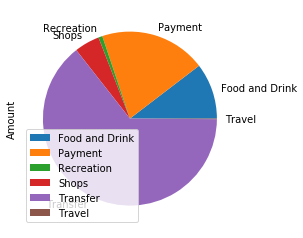

In [10]:
#pie chart of exp per category
spending_per_category.plot.pie(subplots=True)

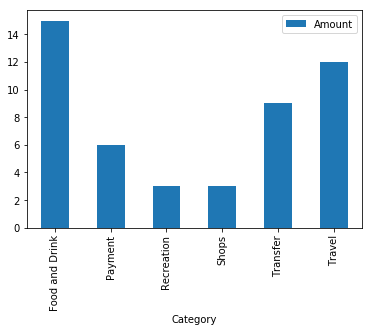

In [207]:
#Generate a bar chart with the number of transactions for each category 
count_of_transactions = spendingtotal.groupby(['Category']).count()
count_of_transactions.plot.bar()

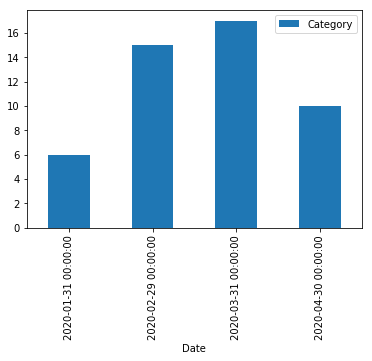

In [233]:
#Calculate the expenses per month
bar_chart = spendingtotal.groupby(pd.Grouper(freq='M')).count()
bar_chart.drop(columns = ['Amount'],inplace=True)
bar_chart.plot.bar()
